# Contenuti
- [Import](#Import)
- [Dataset casuale](#Dataset-casuale)
- [Esempio con scikit-learn](#Esempio-con-scikit-learn)
- [Implementazione K-means](#Implementazione-K-means)
    - [Selezione casuale dei centroidi iniziali](#Selezione-casuale-dei-centroidi-iniziali)
    - [Assegnazione dei pattern](#Assegnazione-dei-pattern)
    - [Aggiornamento dei centroidi](#Aggiornamento-dei-centroidi)
    - [K-means](#K-means)
    - [Esecuzione](#Esecuzione)
- [Trovare il numero di profumi presenti](#Trovare-il-numero-di-profumi-presenti)
    - [Dataset](#Dataset)
    - [Esercizio](#Esercizio)

# Esercitazione 6
Nell'esercitazione odierna si implementerà l'algoritmo *K-means*. Verrà chiesto di implementarne le parti fondamentali, verificarne il corretto funzionamento e infine di utilizzare l'algoritmo sviluppato per risolvere un problema di clustering.

# Import
Per prima cosa è necessario eseguire l'import delle librerie utilizzate durante l'esecitazione.

In [1]:
%matplotlib inline
########
# Nota: se appare un warning relativo a un memory leak su Windows,
# decommentare le seguenti 2 righe di codice:
#import os
#os.environ['OMP_NUM_THREADS'] = '2'
########

import numpy as np
import matplotlib.pyplot as plt
import random

import ml_utilities
import ml_visualization

# Dataset casuale
Durante la fase di implementazione del *K-means* verrà utilizzato un dataset di esempio generato casualmente per poter verificare in maniera semplice il corretto funzionamento dell'algoritmo.

Scikit-learn mette a disposizione la funzione [**make_blobs(...)**](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html) per generare raggruppamenti di punti con distribuzione gaussiana. Variando i parametri *n_samples* (numero totale di punti generati), *centers* (numero di raggruppamenti) e *random_state* (seme iniziale per la generazione casuale) è possibile ottenere dataset differenti.

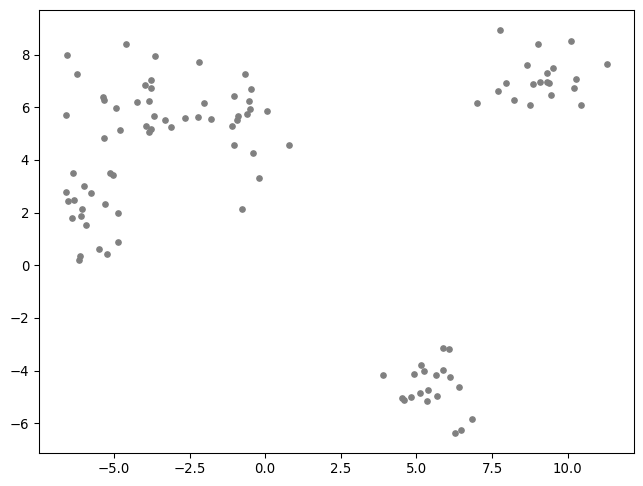

In [2]:
# Generazione di un dataset casuale
from sklearn.datasets import make_blobs

data, _ = make_blobs(n_samples=100, centers=5, random_state=1234)

plt.figure(num=0, dpi=96, figsize=(8, 6))
plt.scatter(data[:,0], data[:,1], c='grey', marker='o', s=16)
plt.show()

# Esempio con scikit-learn
La libreria Scikit-learn fornisce un'implementazione dei più importanti algoritmi di clustering. Per maggiori informazioni si rimanda alla [documentazione ufficiale](https://scikit-learn.org/stable/modules/clustering.html).

Di seguito un esempio di come utilizzare l'algoritmo *K-means* di Scikit-learn sul dataset appena generato.

c:\Users\Lorenzo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


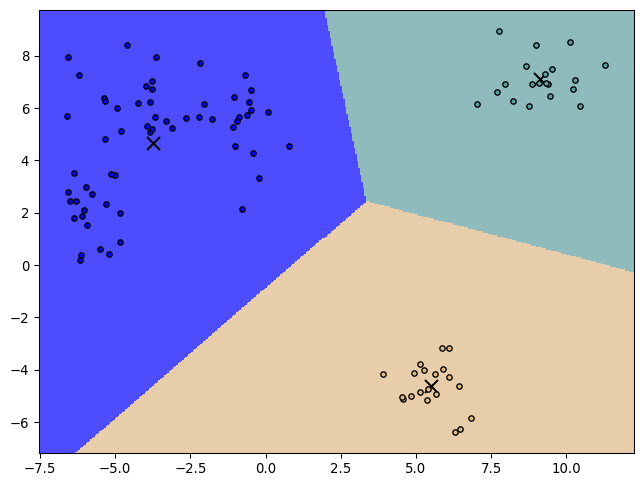

In [3]:
# Import della libreria
from sklearn.cluster import KMeans

# Definizione del numero di cluster attesi
n_clusters = 3

# Creazione dell'istanza di KMeans e addestramento
kmeans = KMeans(n_clusters=n_clusters, random_state=1234, n_init=1)
kmeans.fit(data)

# Visualizzazione dei risultati
plt.figure(num=0, dpi=96, figsize=(8, 6))
ml_visualization.draw_clustering_decision_boundaries(data, kmeans.labels_, kmeans.cluster_centers_, step=0.05)
plt.show()

È possibile ottenere i centroidi dei vari cluster utilizzando l'attributo **cluster\_centers\_** come mostrato nell'esempio seguente:

In [4]:
print('Centroidi ottenuti:\n', kmeans.cluster_centers_)

Centroidi ottenuti:
 [[-3.72957255  4.64690196]
 [ 5.51366983 -4.64045731]
 [ 9.11338955  7.10348958]]


Come per i classificatori, in Scikit-learn gli algoritmi di clustering mettono a disposizione il metodo **.predict(...)** che permette di ottenere l'indice del cluster a cui un pattern viene assegnato.

In [5]:
# Esempio di uso della funzione predict
print('Cluster predetti:\n', kmeans.predict([[-2.5, 0.0], [2.5, -4.0], [0.0, 5.0]]))

Cluster predetti:
 [0 1 0]


# Implementazione K-means
Per poter sviluppare la nostra versione dell'algoritmo si dovranno implementare le seguenti funzioni:
- **assign_patterns_to_clusters(...)** che restituisca un vettore contenente l’indice del cluster a cui è stato assegnato ogni pattern del dataset.
- **compute_centroids(...)** che dovrà restituire i nuovi centroidi calcolati come media dei pattern appartenenti ad ogni cluster.

Queste funzioni verranno successivamente richiamate all'interno della funzione **kmeans_execution(...)** che implementa l'intero *K-means*.

## Selezione casuale dei centroidi iniziali
Il primo passo del *K-means* richiede che vengano scelti casualmente $s$ (numero di cluster) pattern da utilizzare come centroidi iniziali.

La funzione **select_random_centroids(...)** restituisce $s$ centroidi scelti casualmente dai pattern di *data*. Sia il parametro *data* che il valore di ritorno sono **ndarray** bidimensionali in cui i pattern sono memorizzati per riga.

Nota: il parametro *seed* viene utilizzato per l’inizializzazione del generatore di numeri casuali. Per ulteriori dettagli si faccia riferimento alla documentazione della libreria [**random**](https://docs.python.org/3.6/library/random.html). A parità di *seed* il risultato della funzione non cambia in esecuzioni successive. La funzione **random.sample(...)** permette di selezionare un sottoinsieme di elementi da una lista (risolve il problema di selezionare più volte lo stesso elemento).

In [6]:
# La funzione restituisce s centroidi scelti casualmente tra i pattern di data

# data: ndarray bidimensionale in cui i pattern sono memorizzati per riga. Shape = (n_patterns, 2)
# s: numero intero, indica il numero di centroidi da selezionare
# seed: numero intero, utilizzato per inizializzare il generatore di numeri casuali

# Risultato: ndarray bidimensionale in cui i centroidi sono memorizzati per riga. Shape = (s, 2)

def select_random_centroids(data, s, seed):
    random.seed(seed)
    centroid_indices = random.sample(range(data.shape[0]), s)
    return data[centroid_indices]

## Assegnazione dei pattern
Ad ogni iterazione i pattern del dataset devono essere assegnati al cluster per cui è minima la distanza dal corrispondente centroide.

Si implementi la funzione **assign_patterns_to_clusters(...)** che restituisca un **ndarray** monodimensionale (*labels*) contenente l’indice del cluster a cui è stato assegnato ogni pattern. Per individuare il centroide più vicino ad ogni pattern è possibile utilizzare la funzione **compute_square_euclidean_distance(...)** già disponibile nella libreria ml_utilities.

Inoltre si dovrà calcolare e restituire la somma dei quadrati delle distanze di tutti i pattern $\boldsymbol{x}$ dai centroidi a cui sono stati assegnati (*sum_square_distances*), indicata con $J_e$:

$\Large{J_e = \sum_{i=1...s} \sum_{\boldsymbol{x} \in C_i} \lVert \boldsymbol{x} - \boldsymbol{\overline{x}_i} \rVert^2}$

$\Large{\boldsymbol{\overline{x}_i} = \frac{1}{n_i} \sum_{\boldsymbol{x} \in C_i} \boldsymbol{x}}$

dove $C_i$ è l'i-esimo cluster, $n_i$ il numero di pattern che contiene e $\boldsymbol{\overline{x}_i}$ il suo centroide (media).

In [7]:
# Esercizio 1: si completi il codice della funzione assign_patterns_to_clusters
# La funzione deve restituire un vettore contenente l'indice del cluster a cui
# è stato assegnato ogni pattern

# data: ndarray bidimensionale in cui i pattern sono memorizzati per riga. Shape = (n_patterns, 2)
# centroids: ndarray bidimensionale in cui i centroidi sono memorizzati per riga. Shape = (s, 2)

# Risultato 1: ndarray monodimensionale in cui sono memorizzate le etichette dei pattern. Shape = (n_patterns,)
# Risultato 2: valore numerico, somma dei quadrati delle distanze dei pattern dai centroidi a cui sono assegnati

def assign_patterns_to_clusters(data, centroids):
    # Calcola le distanze tra ogni pattern e tutti i centroidi
    distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
    
    # Trova il centroide più vicino per ogni pattern
    labels = np.argmin(distances, axis=1)
    
    # Calcola la somma dei quadrati delle distanze minime
    sum_square_distances = np.sum(np.min(distances, axis=1) ** 2)
    
    return labels, sum_square_distances

    

## Aggiornamento dei centroidi
Una volta assegnati i pattern ai rispettivi cluster è necessario calcolare i nuovi centroidi come media dei pattern appartenenti ad ogni cluster.

Si implementi la funzione **compute_centroids(...)** in modo tale che questa restituisca un **ndarray** bidimensionale (*centroids*) contenente i nuovi centroidi (memorizzati per riga).

In [8]:
# Esercizio 2: si completi il codice della funzione compute_centroids
# La funzione deve restituire i nuovi centroidi calcolati come media
# dei pattern appartenenti ad ogni cluster

# data: ndarray bidimensionale in cui i pattern sono memorizzati per riga. Shape = (n_patterns, 2)
# labels: ndarray monodimensionale in cui sono memorizzate le etichette dei pattern. Shape = (n_patterns,)
# s: numero intero, indica il numero di centroidi da selezionare

# Risultato: ndarray bidimensionale in cui i centroidi sono memorizzati per riga. Shape = (s, 2)

def compute_centroids(data, labels, s):
    # Inizializza i centroidi con NaN per gestire i cluster vuoti senza ciclo
    centroids = np.full((s, data.shape[1]), np.nan)
    
    # Calcola la somma e il conteggio per ogni cluster in una singola operazione
    for i in range(s):
        mask = labels == i
        count = np.sum(mask)
        if count > 0:
            centroids[i] = np.sum(data[mask], axis=0) / count

    return centroids

## K-means
Le parti appena implementate costituiscono i blocchi fondamentali su cui si basa l'algoritmo *K-means*. La cella seguente definisce la funzione **kmeans_execution(...)** che, utilizzando le funzioni appena sviluppate, esegue l'algoritmo restituendo:

- l'indice del cluster a cui è stato assegnato ogni pattern di input (*labels*);
- la lista dei centroidi di ogni cluster (*centroids*);
- la somma dei quadrati delle distanze (*sum_square_distances*);
- il numero di iterazioni eseguite (*iteration_count*).

In [9]:
def kmeans_execution(data, s, max_iteration_count, seed):
    centroids = select_random_centroids(data, s, seed)
    iteration_count = 0
    modified = True
    while modified and iteration_count < max_iteration_count:
        labels, sum_square_distances = assign_patterns_to_clusters(data, centroids)
        new_centroids = compute_centroids(data, labels, s)
        modified = not np.array_equal(centroids, new_centroids)
        centroids = new_centroids
        iteration_count += 1

    return labels, centroids, sum_square_distances, iteration_count

## Esecuzione
Il codice contenuto nella cella seguente richiama la funzione **kmeans_execution(...)** sul dataset generato in precedenza e ne visualizza i risultati.

Si verifichi il funzionamento dell’algoritmo al variare del numero di cluster ($s$), del seme per la scelta casuale dei centroidi iniziali (*seed*) e del massimo numero di iterazioni consentite (*max_iteration_count*).

81.38730141786982
Somma quadrati distanze: 81.387
Numero di iterazioni: 9


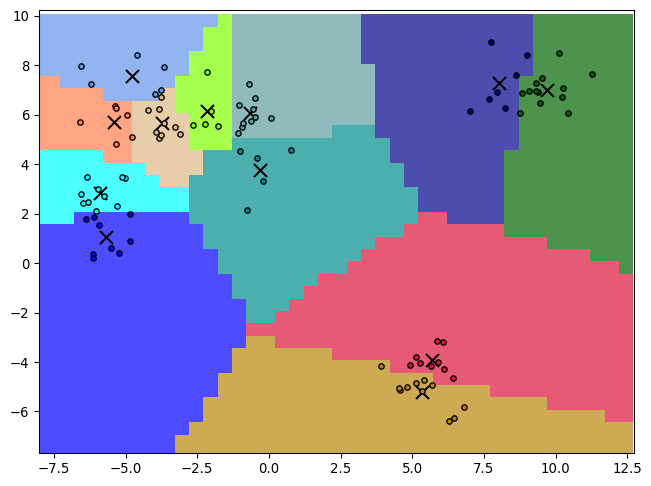

In [10]:
s = 12
seed = 5
max_iteration_count = 30

labels, centroids, sum_square_distances, iteration_count = kmeans_execution(data, s, max_iteration_count, seed)
print(sum_square_distances)
print('Somma quadrati distanze: %0.3f' % sum_square_distances)
print('Numero di iterazioni:', iteration_count)

plt.figure(num=0, dpi=96, figsize=(8, 6))
ml_visualization.draw_clustering_decision_boundaries(data, labels, centroids, step=0.5)
plt.show()

# Trovare il numero di profumi presenti
Si utilizzi l’algoritmo *K-means* appena implementato per stimare il numero corretto di raggruppamenti (cluster) presenti in un dataset non etichettato.

## Dataset
Il dataset "Profumi.txt" contiene un insieme di pattern bidimensionali non etichettati acquisiti analizzando con due sensori di odore un insieme di profumi. Di seguito è riportata la procedura per il caricamento del dataset:

Shape del dataset: (490, 2)


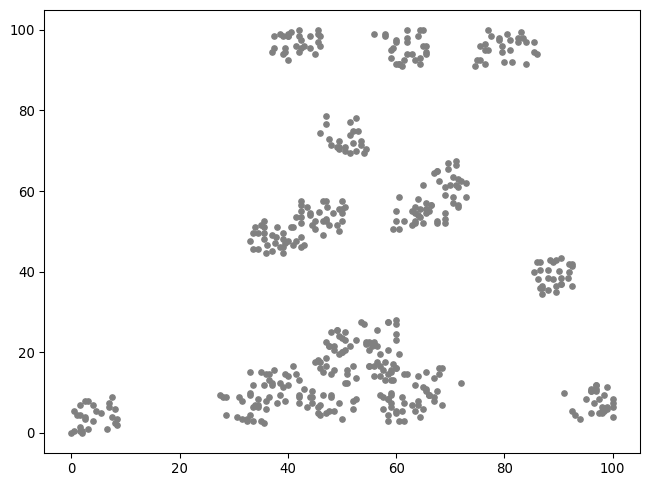

In [11]:
dataset_file_path = 'DBs/Profumi/Profumi.txt'
data = np.loadtxt(dataset_file_path)

print('Shape del dataset:', data.shape)

plt.figure(num=0, dpi=96, figsize=(8, 6))
plt.scatter(data[:,0], data[:,1], c='gray', marker='o', s=16)
plt.show()

c:\Users\Lorenzo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


For n_clusters = 2, the average silhouette_score is: 0.4910371832255219


c:\Users\Lorenzo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\Lorenzo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


For n_clusters = 3, the average silhouette_score is: 0.4226038979904787
For n_clusters = 4, the average silhouette_score is: 0.5189219117145251


c:\Users\Lorenzo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\Lorenzo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


For n_clusters = 5, the average silhouette_score is: 0.5562297715103847
For n_clusters = 6, the average silhouette_score is: 0.5435284914549166


c:\Users\Lorenzo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\Lorenzo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


For n_clusters = 7, the average silhouette_score is: 0.517483272712808
For n_clusters = 8, the average silhouette_score is: 0.5463158929883324


c:\Users\Lorenzo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\Lorenzo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


For n_clusters = 9, the average silhouette_score is: 0.5595544722582447
For n_clusters = 10, the average silhouette_score is: 0.6060560870404401


c:\Users\Lorenzo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


For n_clusters = 11, the average silhouette_score is: 0.6064464419807761


c:\Users\Lorenzo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\Lorenzo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


For n_clusters = 12, the average silhouette_score is: 0.592780931849901
For n_clusters = 13, the average silhouette_score is: 0.6255031146629072


c:\Users\Lorenzo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\Lorenzo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


For n_clusters = 14, the average silhouette_score is: 0.6102591877282733
For n_clusters = 15, the average silhouette_score is: 0.6003480523647505


c:\Users\Lorenzo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


For n_clusters = 16, the average silhouette_score is: 0.5758352836142213


c:\Users\Lorenzo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


For n_clusters = 17, the average silhouette_score is: 0.5700089332471773


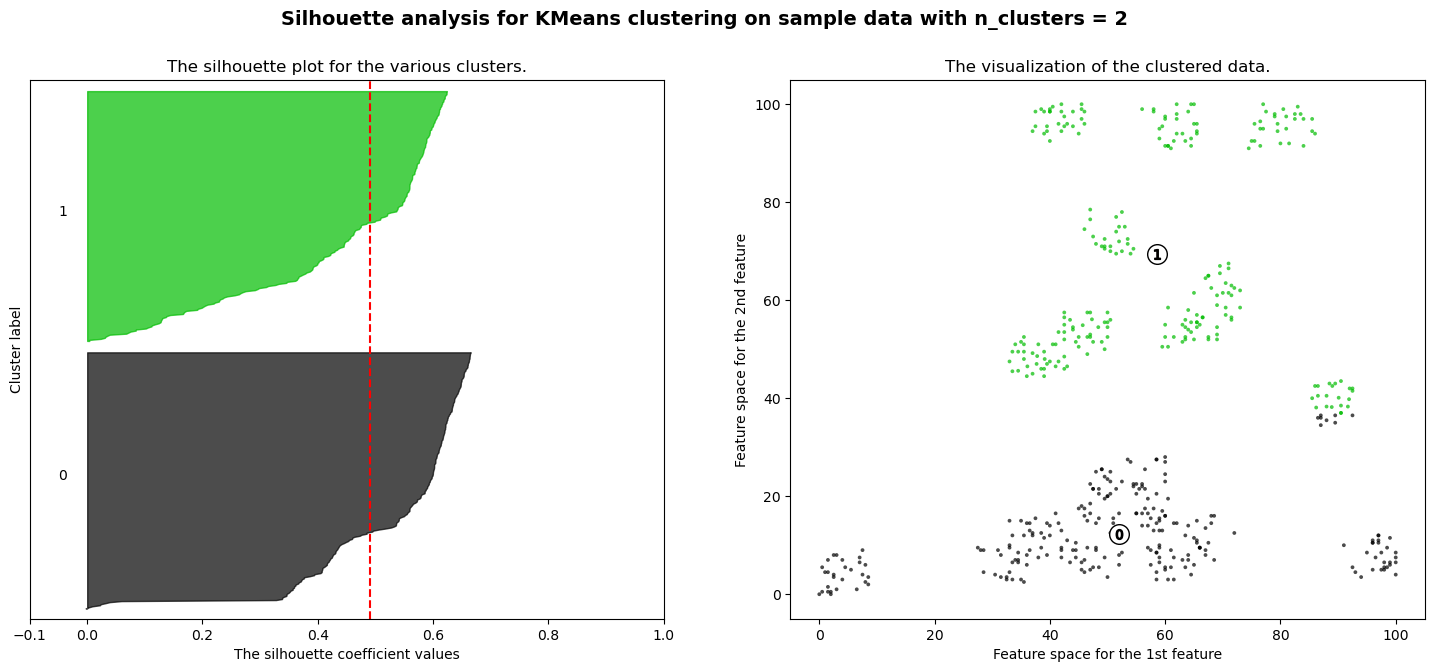

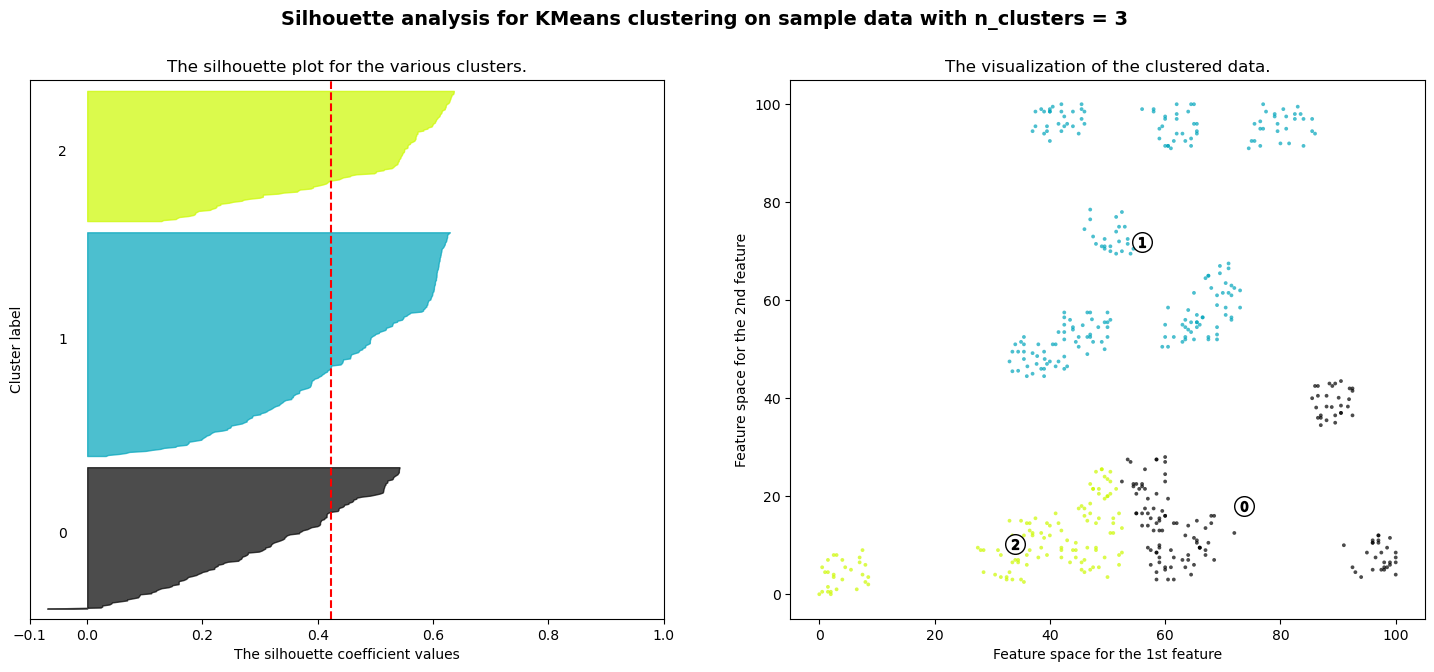

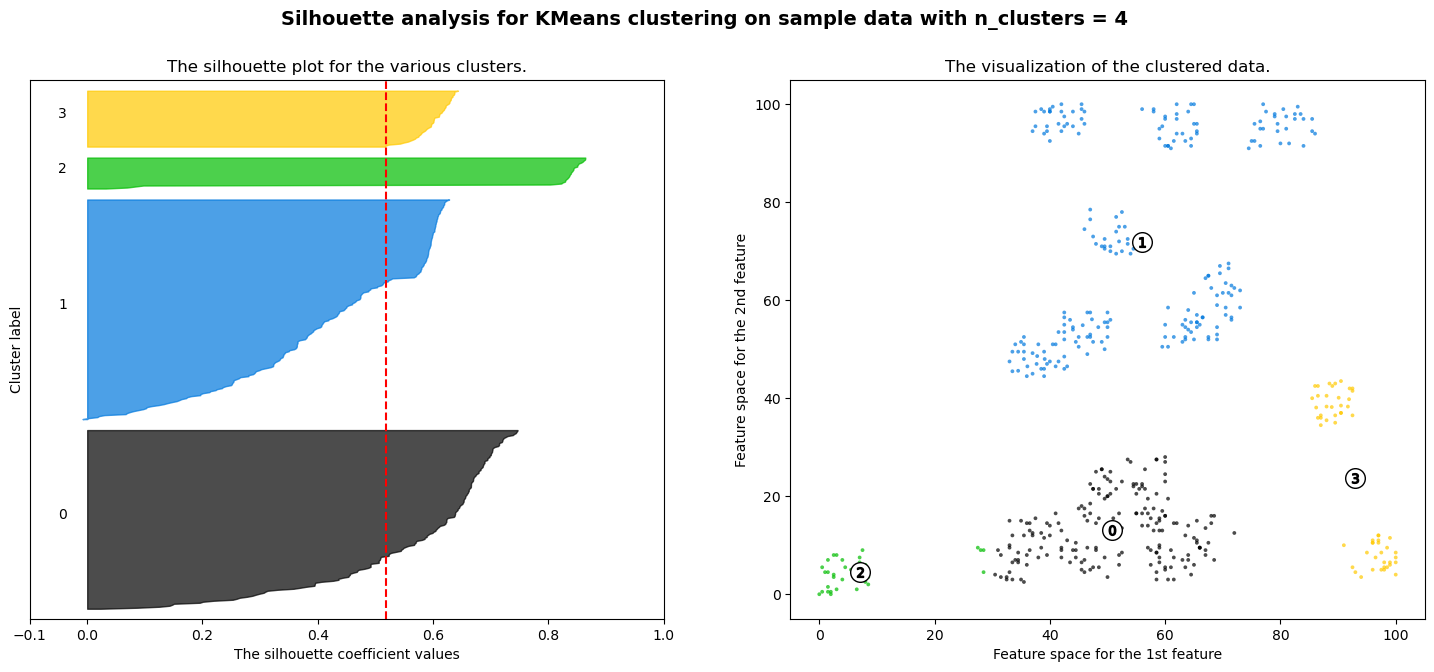

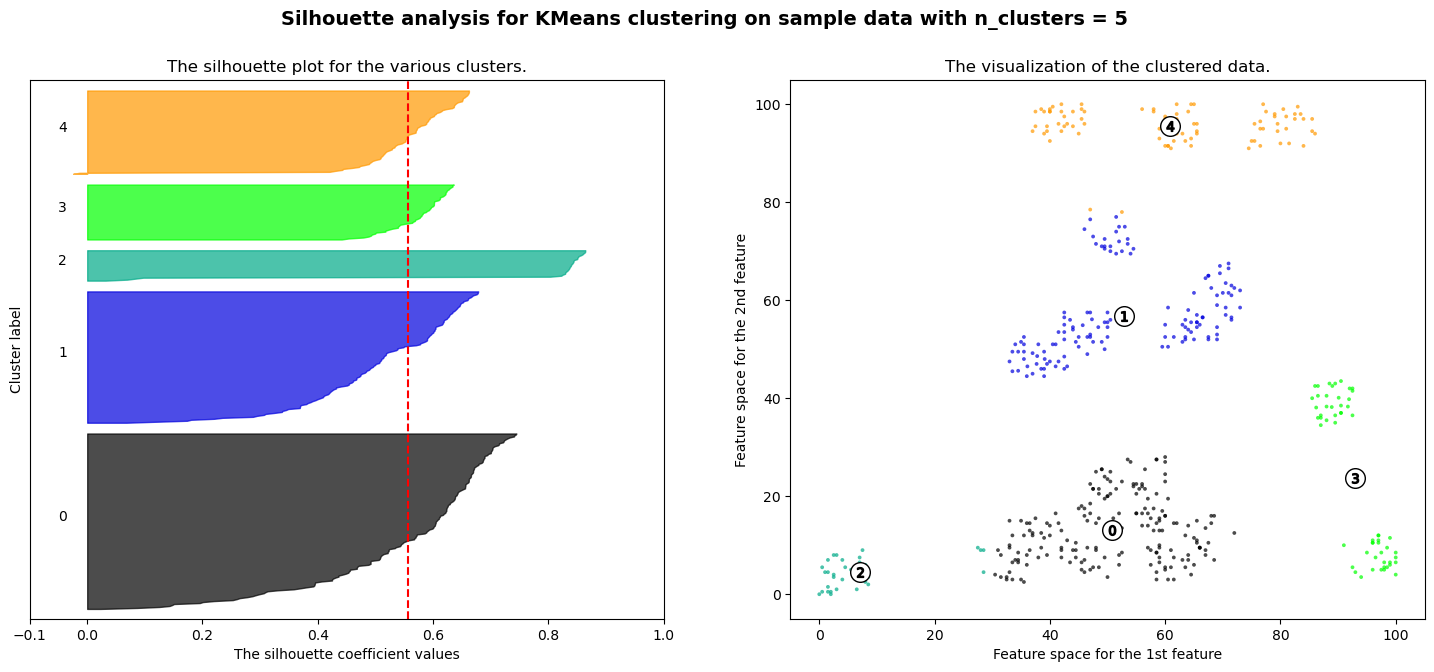

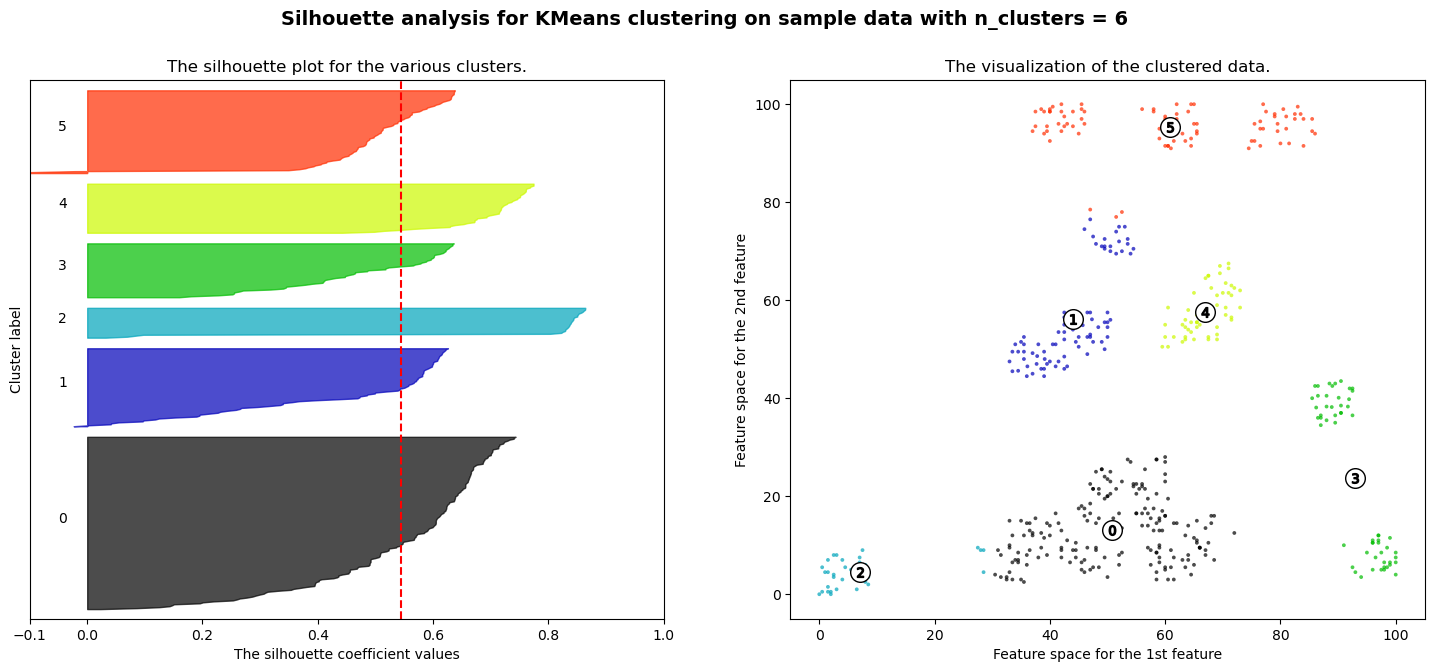

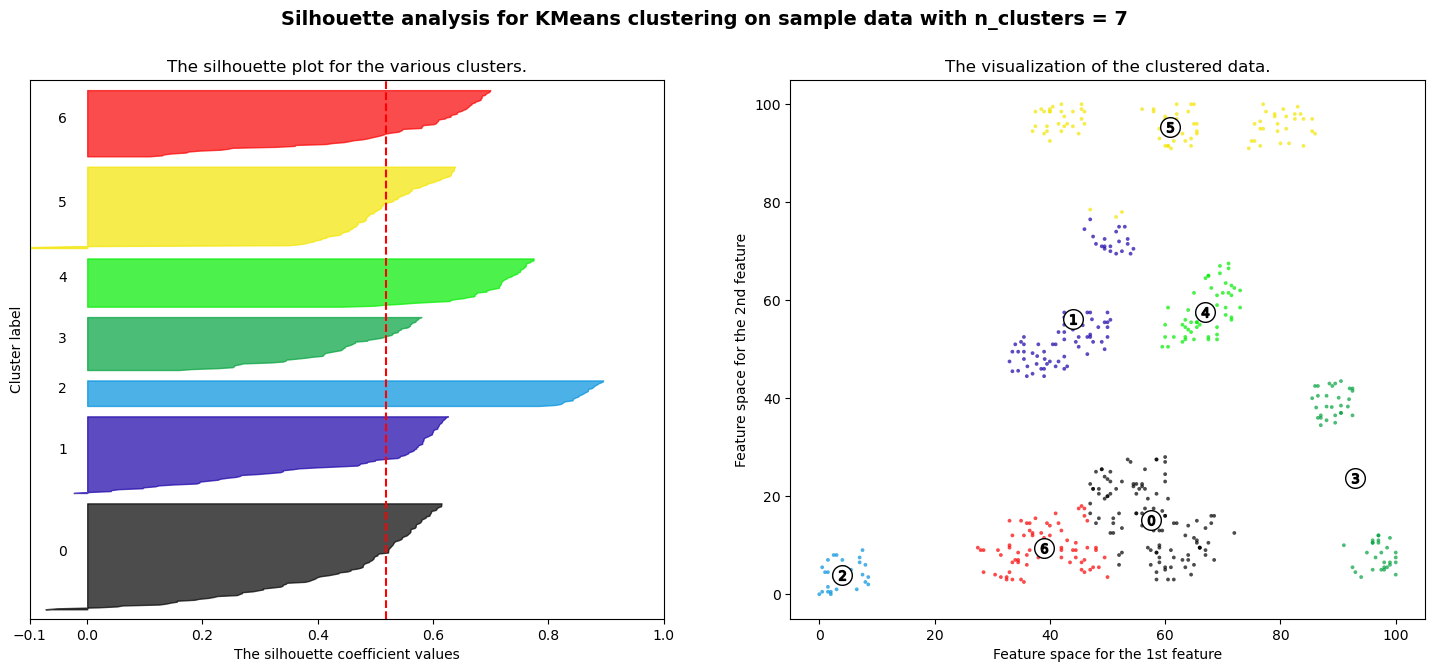

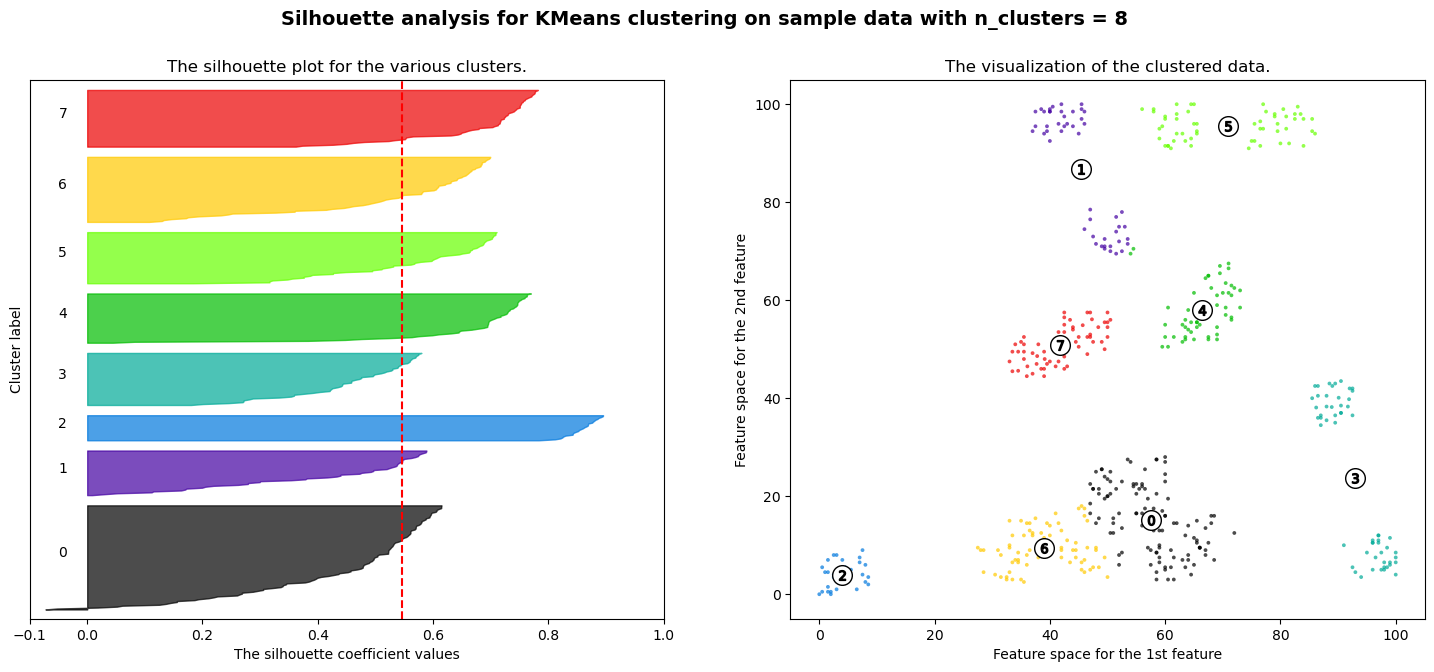

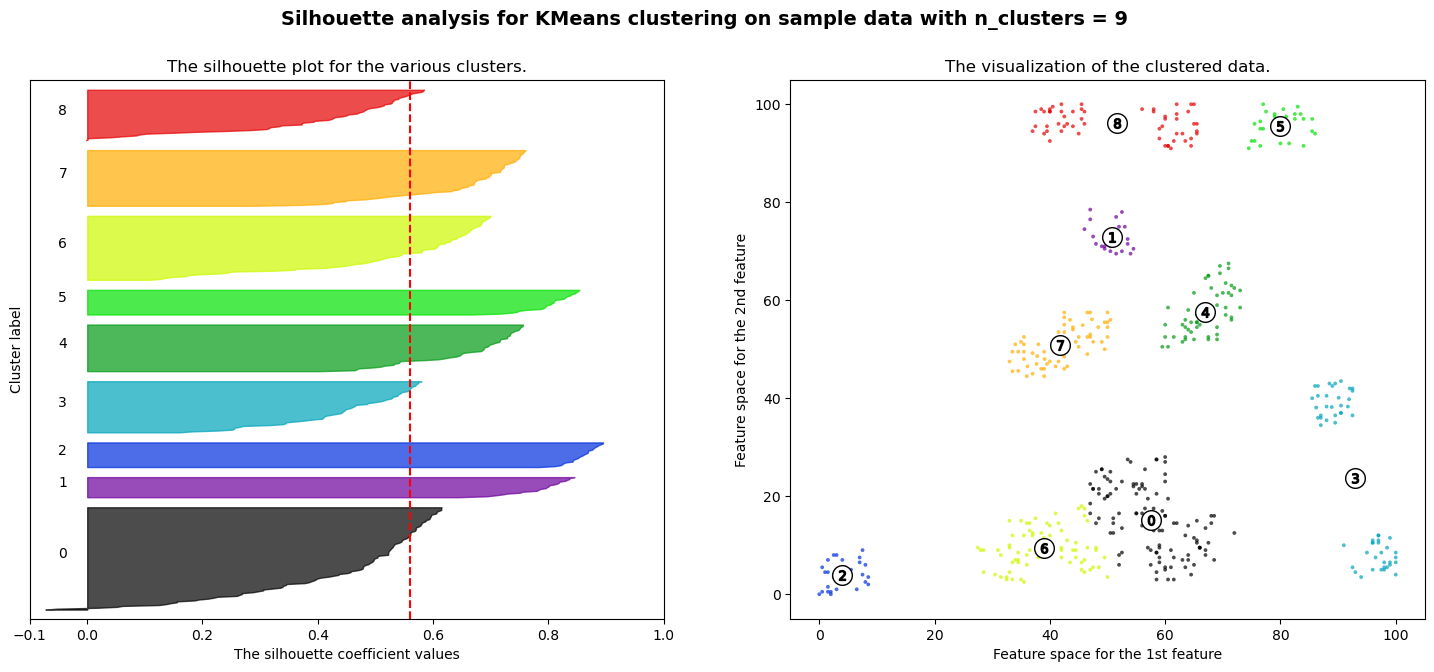

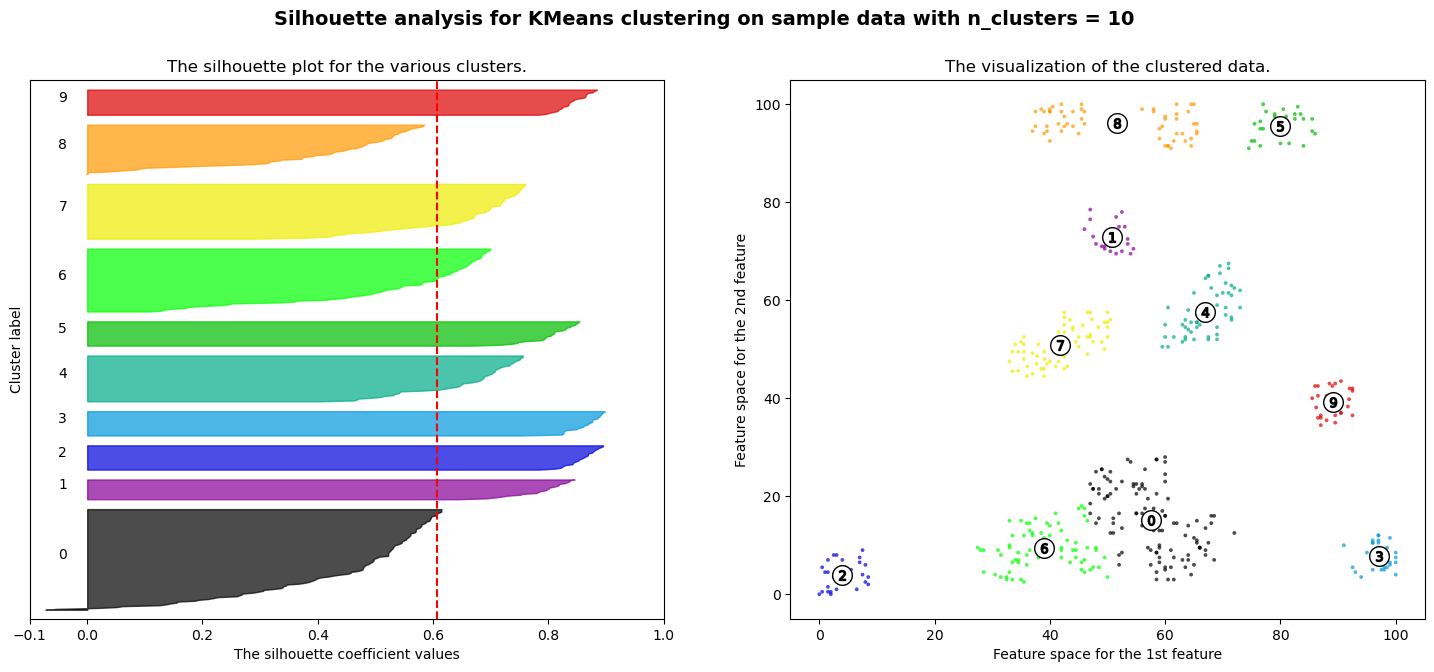

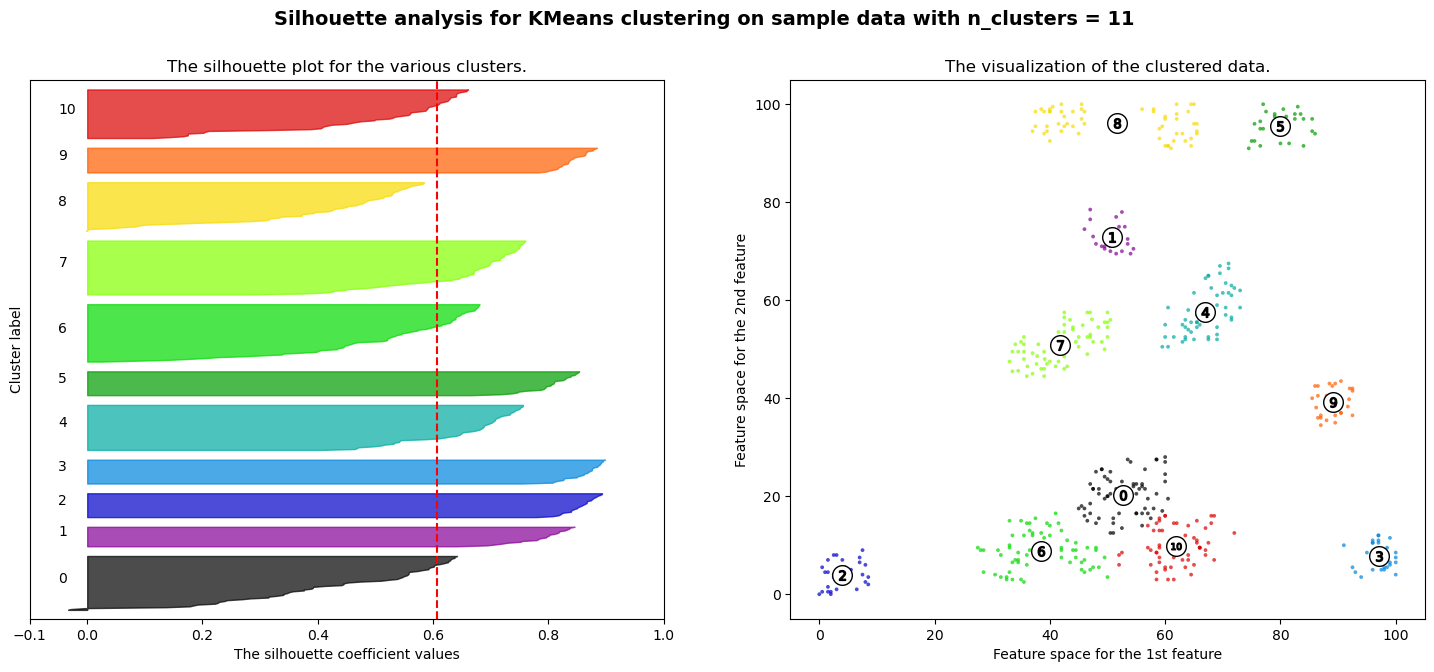

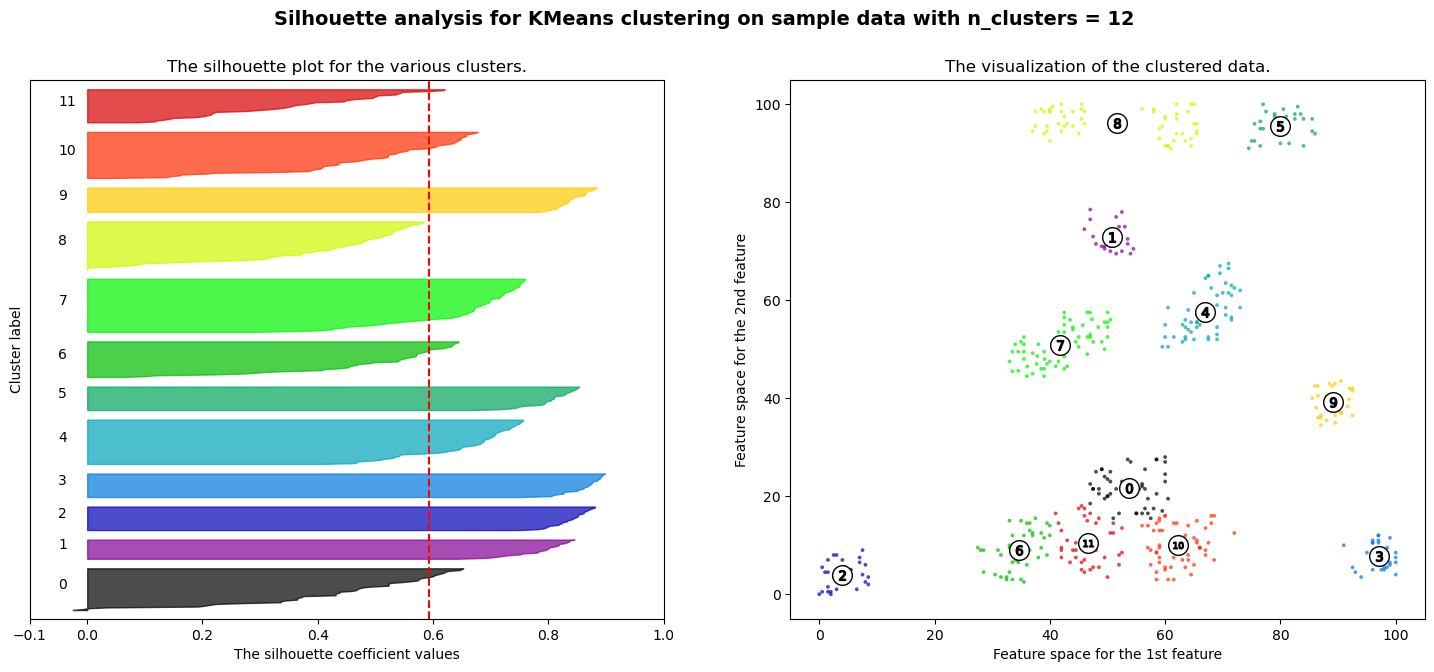

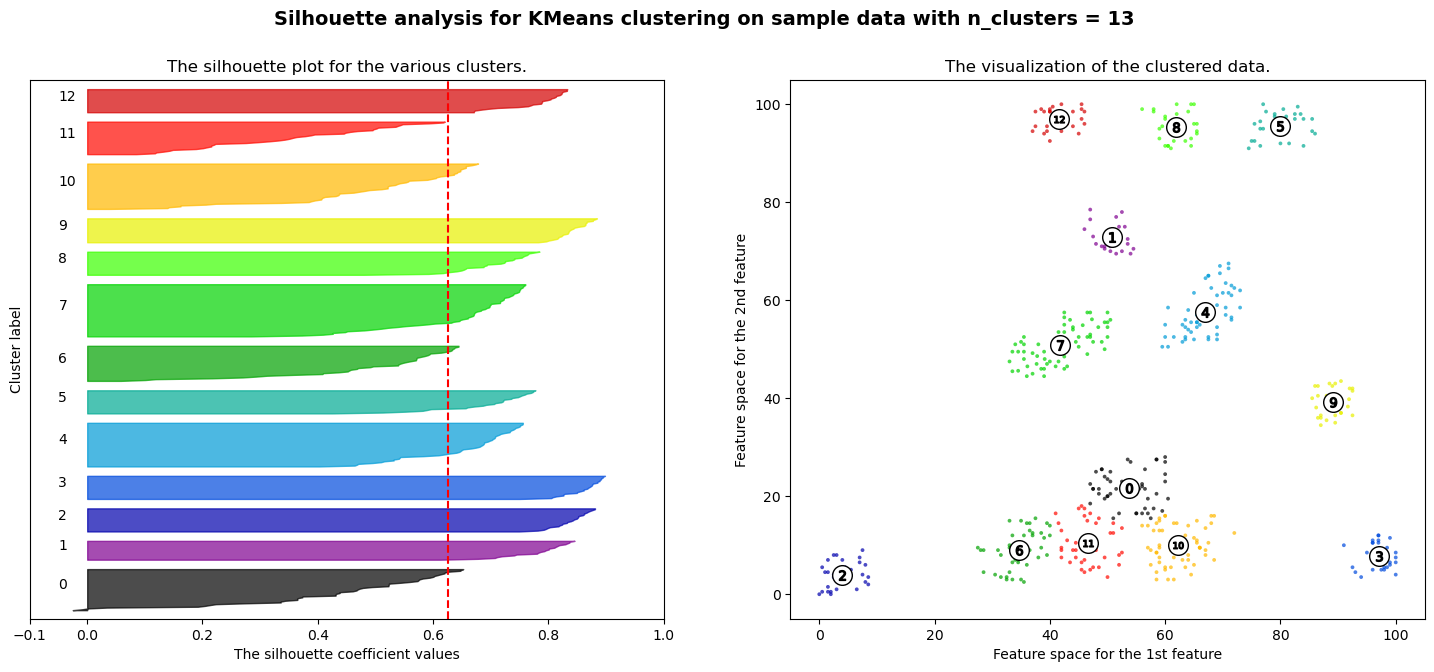

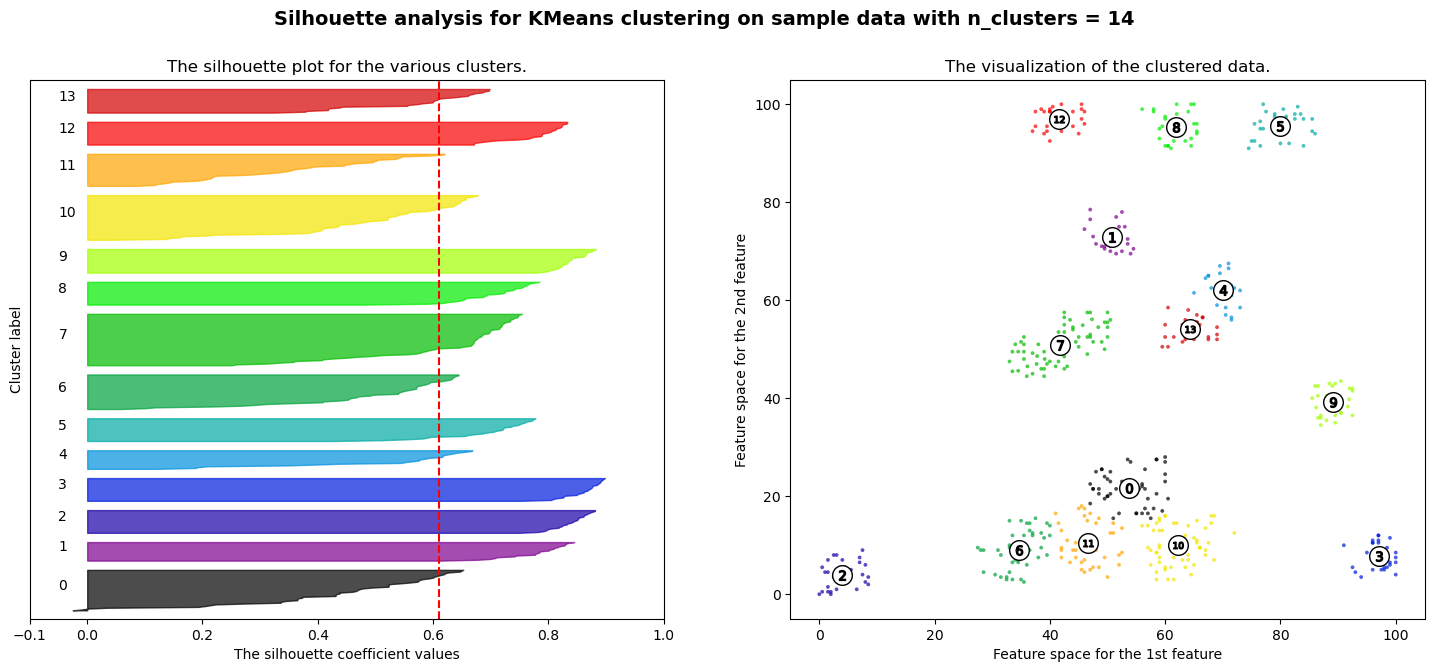

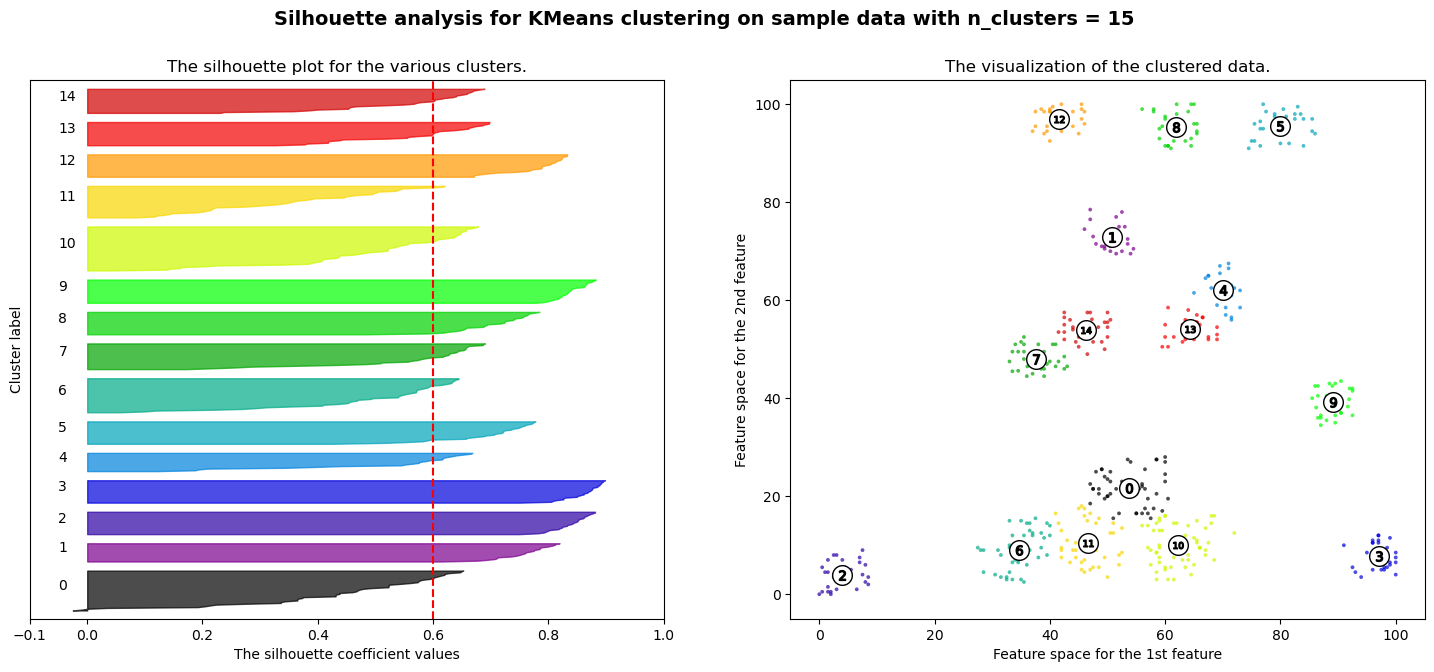

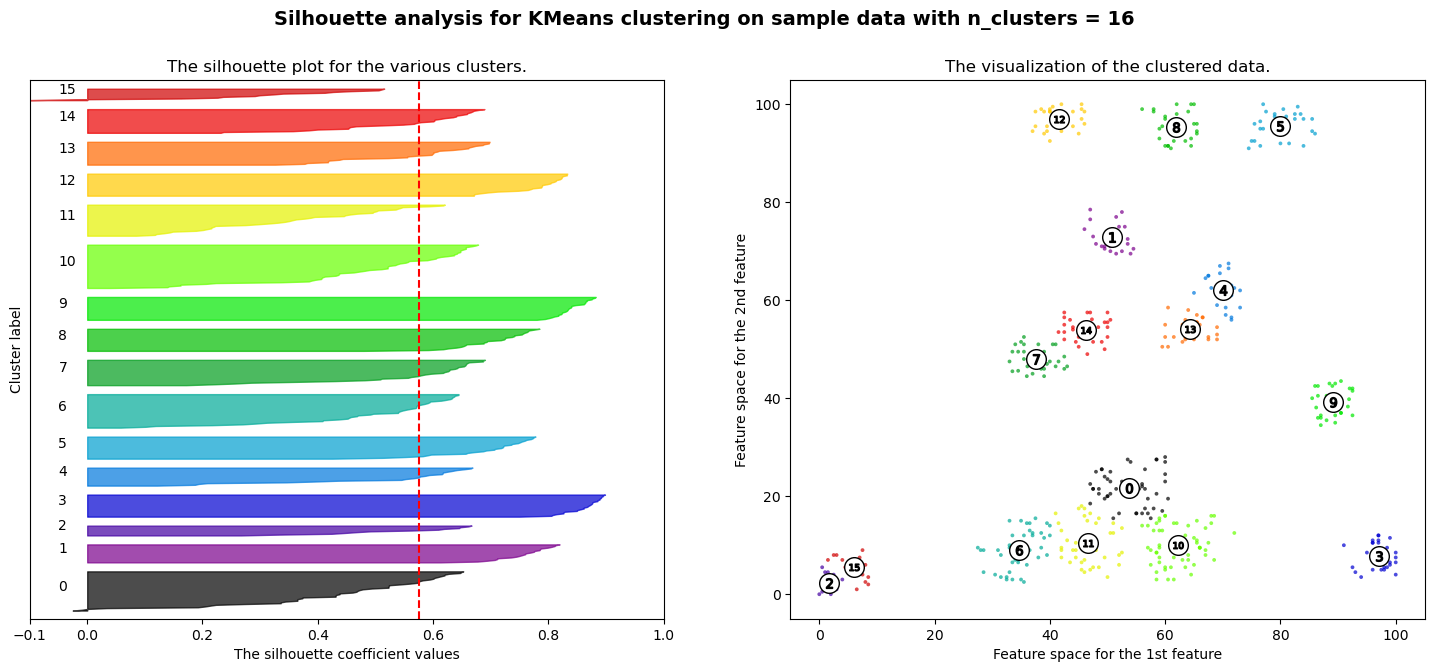

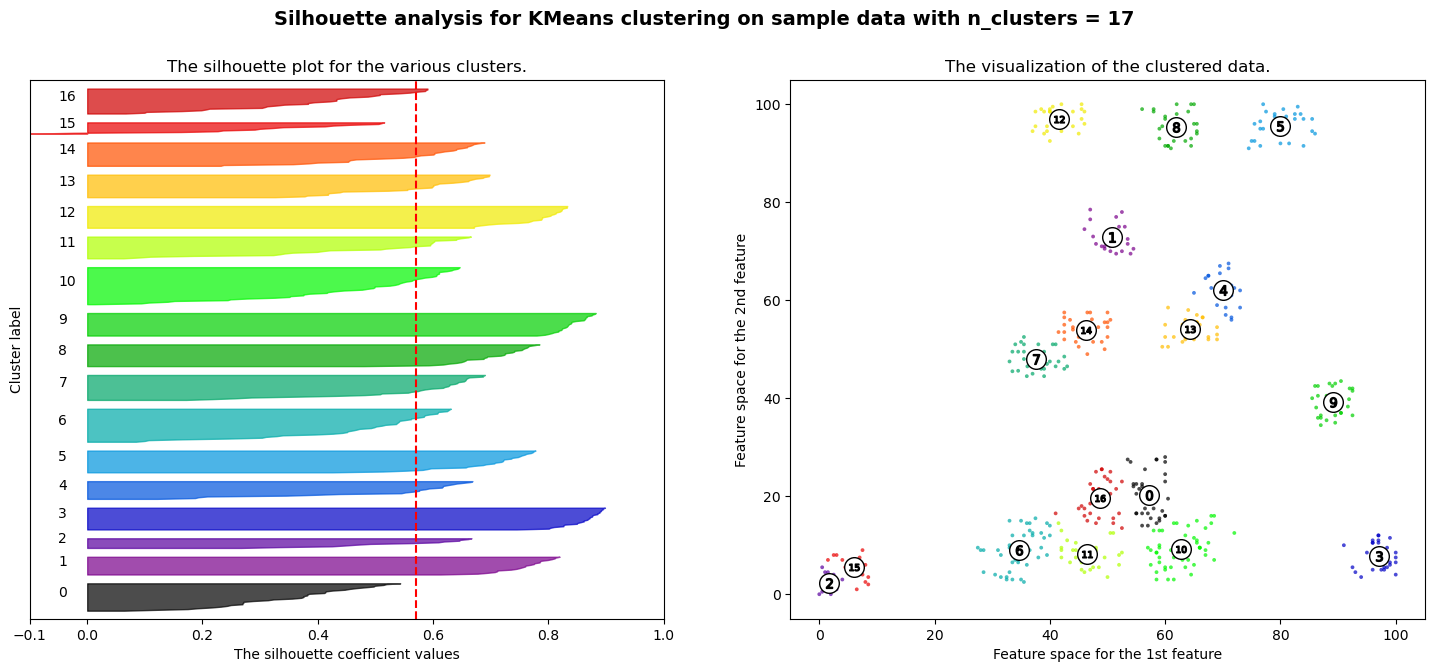

In [12]:
from sklearn.metrics import silhouette_samples, silhouette_score

#siluette analysis

import matplotlib.cm as cm

range_n_clusters = range(2,18)

silhouette_scores = []

for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(data) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=seed, n_init=1)
    cluster_labels = clusterer.fit_predict(data)

    silhouette_avg = silhouette_score(data, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {n_clusters}, the average silhouette_score is: {silhouette_avg}")

    sample_silhouette_values = silhouette_samples(data, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(data[:, 0], data[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")

    centers = clusterer.cluster_centers_
    ax2.scatter(centers[:, 0], centers[:, 1], marker="o", c="white", alpha=1, s=200, edgecolor="k")

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker=f"${i}$", alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(f"Silhouette analysis for KMeans clustering on sample data with n_clusters = {n_clusters}",
                 fontsize=14, fontweight="bold")

plt.show()

## Esercizio

Stimare il numero di profumi analizzati utilizzando l’algoritmo *K-means*. 

Si completi il codice riportato nella cella seguente al fine di eseguire l’algoritmo *K-means* per i diversi valori del numero di cluster ($s$) nell’intervallo \[*s_min*, *s_max*\]. Per evitare che il risultato ottenuto possa essere condizionato da una scelta errata dei centroidi iniziali, consigliamo di eseguire l'algoritmo più volte (*execution_count*) per ogni valore di $s$. Al fine di evitare di ottenere risultati identici, a ogni esecuzione è necessario partire da un insieme di centroidi iniziali differente. Pertanto, il codice genera una matrice di seed diversi (*seeds*) da utilizzare nelle diverse esecuzioni di *K-means*.

Al termine dell’intera esecuzione viene mostrato il grafico del valore minimo di $J_e$ (su *execution_count* esecuzioni per ogni $s$) al variare di $s$. Al fine di rendere possibile la visualizzazione di questi valori è necessario memorizzare nella variabile $y$ il valore minimo di $J_e$ trovato per ogni $s$ (su tutte le esecuzioni - *execution_count*).

Dovendo eseguire il *K-means* un elevato numero di volte, sottenutai consiglia di utilizzare la versione di Scikit-learn perchè più efficiente rispetto alla versione appena implementata. La classe [**KMeans**](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) mette a disposizione gli attributi **inertia\_** e **n\_iter\_** che restituiscono rispettivamente il valore $J_e$ della soluzione ottenuta e il numero di iterazioni eseguite.

Nota: per questi esperimenti, considerato che l'esecuzione ripetuta di KMeans è già controllata dal ciclo su *execution_count*, è conveniente passare a *KMeans* il parametro `n_init=1` (si veda [la documentazione](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans)).

In [13]:
#siluette score
from sklearn.metrics import silhouette_score

c:\Users\Lorenzo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\Lorenzo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\Lorenzo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\Lorenzo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak o

Optimal s: 9
Max sil score: 0.6420216693405505
Optimal seed: 119869


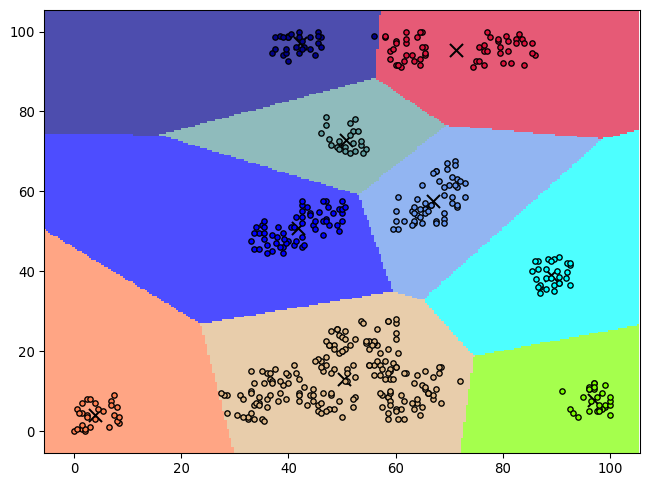

In [17]:
# Esercizio 3: si individui il numero di cluster ottimale nei
# due differenti scenari [5, 15] e [16, 25] modificando i
# successivi parametri, completando il codice e analizzando l'output

s_min = 5
s_max = 15
execution_count = 100
initial_seed = 1
max_iteration_count = 50
max_sil_score = -1
optimal_s = 0
optimal_seed = 0

random.seed(initial_seed)
s = np.array(range(s_min, s_max + 1))
y = np.zeros(s.shape[0])
seeds = np.zeros((s.shape[0], execution_count), dtype=int)

for i in range(s.shape[0]):
    for j in range(execution_count):
        seeds[i, j] = random.randint(0, 1000000)
        #labels, centroids, sum_square_distances, iteration_count = kmeans_execution_real(data, s[i], seeds[i, j])
    
        #if y[i] == 0 or sum_square_distances < y[i]:
        #    y[i] = sum_square_distances
        kmeans = KMeans(n_clusters=s[i], random_state=seeds[i, j], n_init=1)
        kmeans.fit(data)
        sil_score = silhouette_score(data, kmeans.labels_, random_state=seeds[i, j])
        if (max_sil_score <= sil_score):
            max_sil_score = sil_score
            optimal_s = s[i]
            optimal_seed = seeds[i, j]
            optimal_labels = kmeans.labels_
            optimal_centroids = kmeans.cluster_centers_
    
#plt.figure(num=0, dpi=96, figsize=(8, 6))
#plt.plot(s, y, marker='o')
#plt.xlabel('Numero di cluster')
#plt.ylabel('Somma quadrati distanze')
#plt.grid(True)
#plt.show()

#faccio un arrayd dove la prima colonna son numeri da s_min a s_ma, la secodna son le distane minori ottenute e la terza la seed corrispondente
#result = np.column_stack((range(s_min,s_max)))
#print(result)

print("Optimal s:", optimal_s)
print("Max sil score:", max_sil_score)
print("Optimal seed:", optimal_seed)

plt.figure(num=0, dpi=96, figsize=(8, 6))
ml_visualization.draw_clustering_decision_boundaries(data, optimal_labels, optimal_centroids)
plt.show()

In [28]:
def kmeans_execution_real(data, s, seed):
    #fallo con Kmeans
    kmeans = KMeans(n_clusters=s, random_state=seed, n_init=1)
    kmeans.fit(data)
    return kmeans.labels_, kmeans.cluster_centers_, kmeans.inertia_, kmeans.n_iter_

c:\Users\Lorenzo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\Lorenzo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\Lorenzo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\Lorenzo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak o

Optimal s: 17
Max sil score: 0.6049774833448216
Optimal seed: 678592


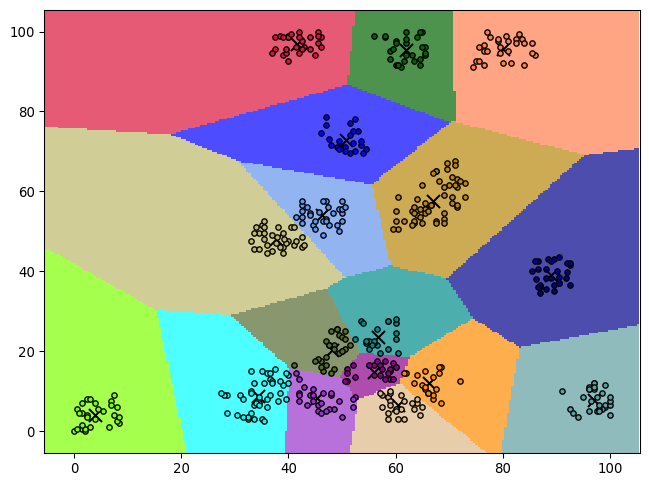

In [18]:
# Esercizio 3: si individui il numero di cluster ottimale nei
# due differenti scenari [5, 15] e [16, 25] modificando i
# successivi parametri, completando il codice e analizzando l'output

s_min = 16
s_max = 25
execution_count = 100
initial_seed = 1
max_iteration_count = 50
max_sil_score = -1
optimal_s = 0
optimal_seed = 0

random.seed(initial_seed)
s = np.array(range(s_min, s_max + 1))
y = np.zeros(s.shape[0])
seeds = np.zeros((s.shape[0], execution_count), dtype=int)

for i in range(s.shape[0]):
    for j in range(execution_count):
        seeds[i, j] = random.randint(0, 1000000)
        #labels, centroids, sum_square_distances, iteration_count = kmeans_execution_real(data, s[i], seeds[i, j])
    
        #if y[i] == 0 or sum_square_distances < y[i]:
        #    y[i] = sum_square_distances
        kmeans = KMeans(n_clusters=s[i], random_state=seeds[i, j], n_init=1)
        kmeans.fit(data)
        sil_score = silhouette_score(data, kmeans.labels_, random_state=seeds[i, j])
        if (max_sil_score <= sil_score):
            max_sil_score = sil_score
            optimal_s = s[i]
            optimal_seed = seeds[i, j]
            optimal_labels = kmeans.labels_
            optimal_centroids = kmeans.cluster_centers_
    
#plt.figure(num=0, dpi=96, figsize=(8, 6))
#plt.plot(s, y, marker='o')
#plt.xlabel('Numero di cluster')
#plt.ylabel('Somma quadrati distanze')
#plt.grid(True)
#plt.show()

#faccio un arrayd dove la prima colonna son numeri da s_min a s_ma, la secodna son le distane minori ottenute e la terza la seed corrispondente
#result = np.column_stack((range(s_min,s_max)))
#print(result)

print("Optimal s:", optimal_s)
print("Max sil score:", max_sil_score)
print("Optimal seed:", optimal_seed)

plt.figure(num=0, dpi=96, figsize=(8, 6))
ml_visualization.draw_clustering_decision_boundaries(data, optimal_labels, optimal_centroids)
plt.show()

Si individui il numero di profumi presenti nel dataset analizzando il grafico. Si faccia attenzione al fatto che, per come è definito $J_e$, valori grandi di $s$ producono più facilmente valori piccoli di $J_e$.

Pertanto per determinare il numero ottimale di cluster (validation) si suggerisce di:

- analizzare il grafico alla ricerca di punti di discontinuità (*elbow*);
- utilizzare *silhouette analysis* (*silhouette score* e *diagram*) presenti in Scikit-learn. Vedi:
https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py


Il codice seguente può essere utilizzato come ulteriore supporto per l'individuazione dell'esatto numero di profumi analizzando visivamente le singole soluzioni ottenute al passo precedente.

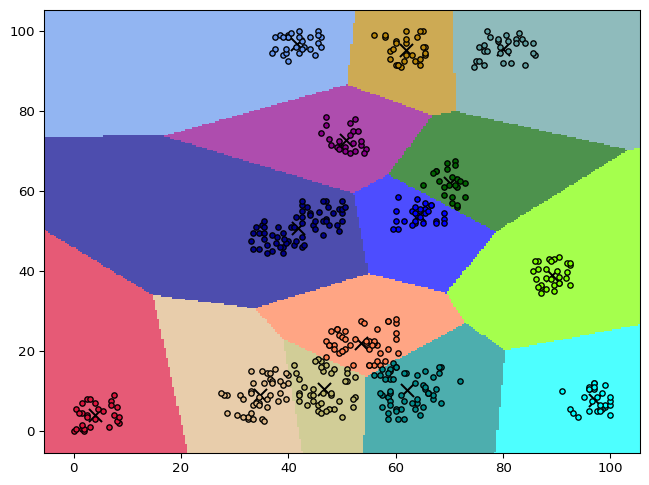

In [53]:
s = 14
seed = 1235

kmeans = KMeans(n_clusters=s, n_init=1)
kmeans.fit(data)

plt.figure(num=0, dpi=96, figsize=(8, 6))
ml_visualization.draw_clustering_decision_boundaries(data, kmeans.labels_, kmeans.cluster_centers_, step=0.4)
plt.show()

In particolare, riportare il numero reale di profumi nel caso in cui $s$ sia compreso tra 5 e 15 e nel caso in cui sia compreso tra 16 e 25.

Memorizzare i due valori di $s$ in un file di testo dal nome "Es6Predictions.txt" (un valore per riga). La cella seguente genera, date le stime di $s_1 \in [5, 15]$ e $s_2 \in [16, 25]$, il file di testo correttamente formattato.

In [19]:
# Assegnare a s_1 e s_2 i valori trovati 
s_1 = 9
s_2 = 17

# Creazione del file di testo
result_path = 'Es6Predictions.txt'
s_values = np.array([s_1, s_2], dtype=int)
np.savetxt(result_path, s_values, fmt='%i')
print('Ok')

Ok
